In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
import random
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import seaborn as sns
import pickle


%matplotlib inline

2025-02-18 16:42:53.759578: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-18 16:42:53.783558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739889773.816790 2981218 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739889773.823120 2981218 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 16:42:53.843752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images as is - before any pre-processing'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [3]:
def subplot_images(num, df, img_index, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from a dataframe with index - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel() 
    for i,img in enumerate(img_index):
        image = df.loc[img,'img_array']
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(df.loc[img,'face_shape'], size=16)

In [4]:
def subplot_img_array(num, img_array, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from an array dataset - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel() 
    for i,img in enumerate(img_array):
        image = img_array[i][0]
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [5]:
# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')

In [6]:
train_dir = './Training'
test_dir = './Testing'
categories = ['Heart','Rectangle','Oval','Round','Square','Triangle']
nr_categories = len(categories)
label_map = {0:'Heart', 1: 'Rectangle', 2: 'Oval', 3: 'Round', 4: 'Square', 5: 'Triangle'}

In [7]:
def create_data_files(directory, array, resize=None):
    '''this function reads the images from the directory and create training & testing datasets'''
    i=0
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the 5 categories
        img_list = os.listdir(path)
        try:
            for img in img_list:            
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                if resize != None:
                  img_array = cv2.resize(img_array, resize)
                array.append([img_array, class_num])
                i += 1
        except Exception as e:
                print(f'Error: \n category: {category}\n image: {img}')
    
        # Print progress every 400 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list*len(categories))}")

In [8]:
# create training & testing data into a list

training_data = []
testing_data = []

create_data_files(train_dir, training_data)
create_data_files(test_dir, testing_data)

# convert them to numpy arrays

training_data = np.asarray(training_data, dtype='object')
testing_data = np.asarray(testing_data, dtype='object')

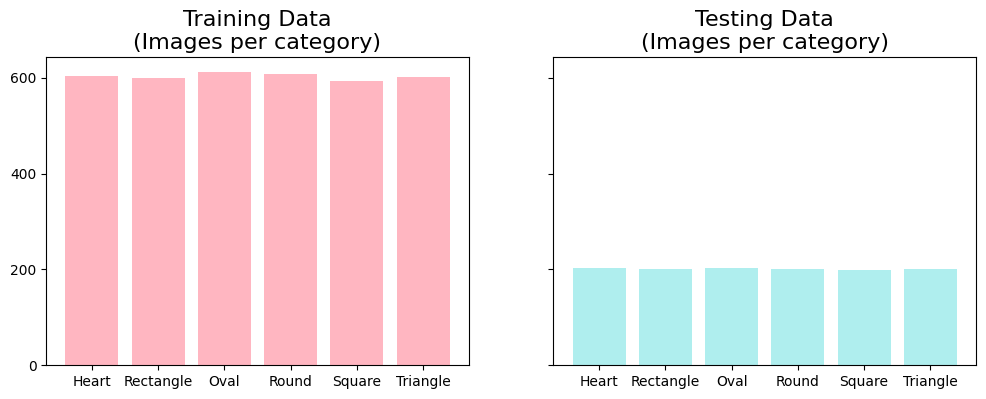

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4),sharex=True, sharey=True)
ax[0].bar(x=categories, height = np.bincount(training_data[:,1].astype(int)),color='lightpink')
ax[0].set_title('Training Data\n(Images per category)', size=16)
ax[1].bar(x=categories, height = np.bincount(testing_data[:,1].astype(int)),color='paleturquoise')
ax[1].set_title('Testing Data\n(Images per category)', size=16)
ax[1].set_yticks(range(0,601,200));

In [10]:
print_summary(training_data, testing_data)


Training Dataset:

Shape: (3620, 2)
Classes: [0 1 2 3 4 5]
No. of Images in each class: [604 600 612 608 594 602]
Max Pixels: 230

--------------------------------------


Testing Dataset:

Shape: (1204, 2)
Classes: [0 1 2 3 4 5]
No. of Images in each class: [202 200 204 200 198 200]
Max Pixels: 244

--------------------------------------



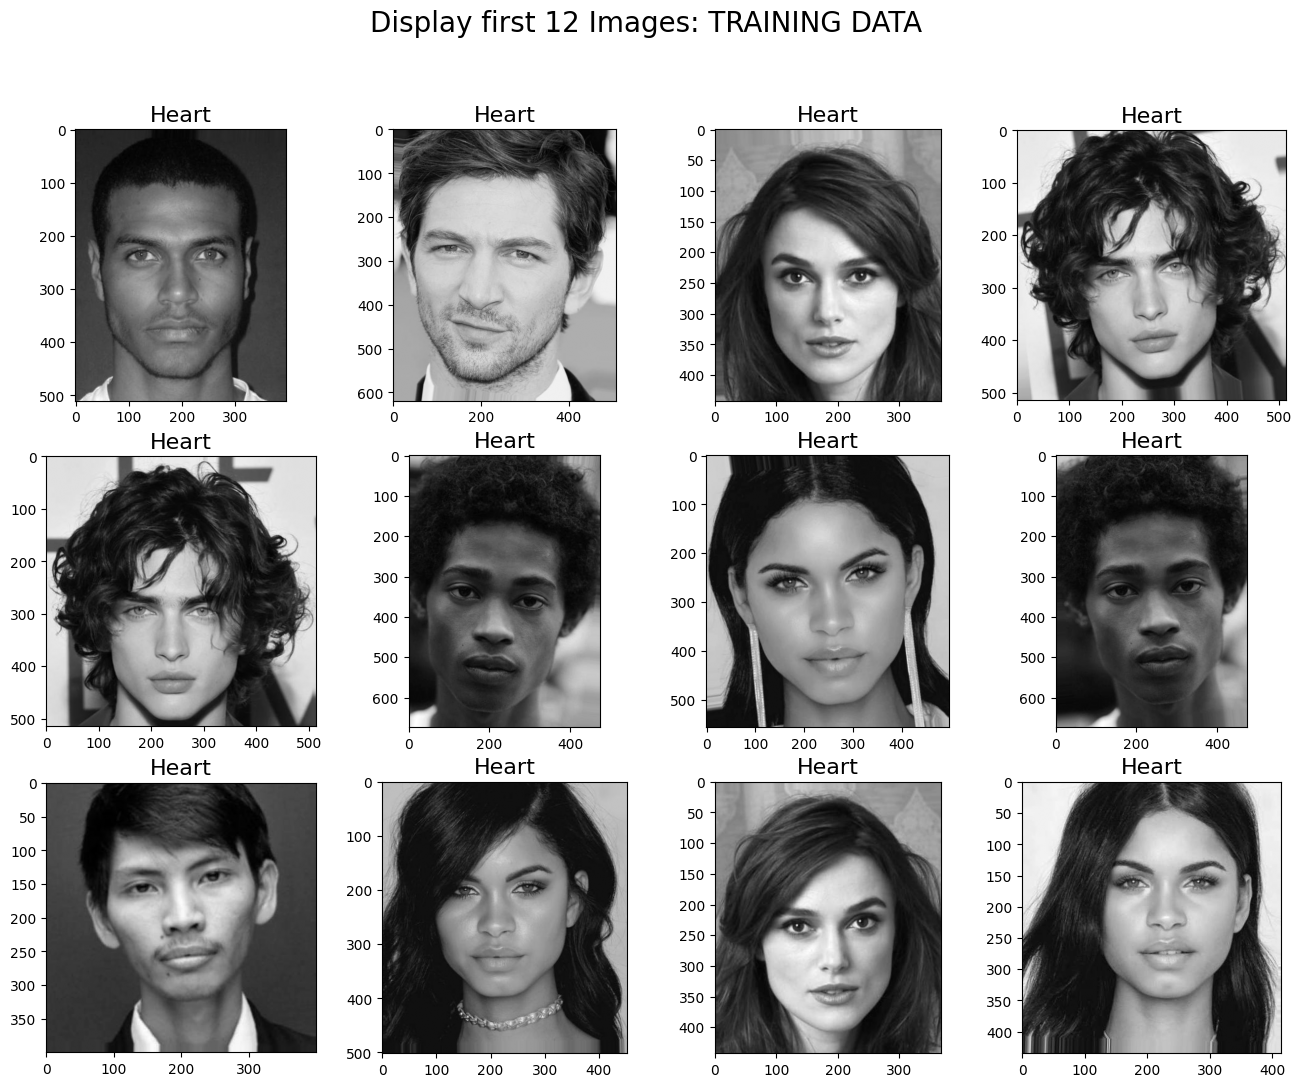

In [11]:
show_img(12, training_data[:12], 'Display first 12 Images: TRAINING DATA', ncols=4)

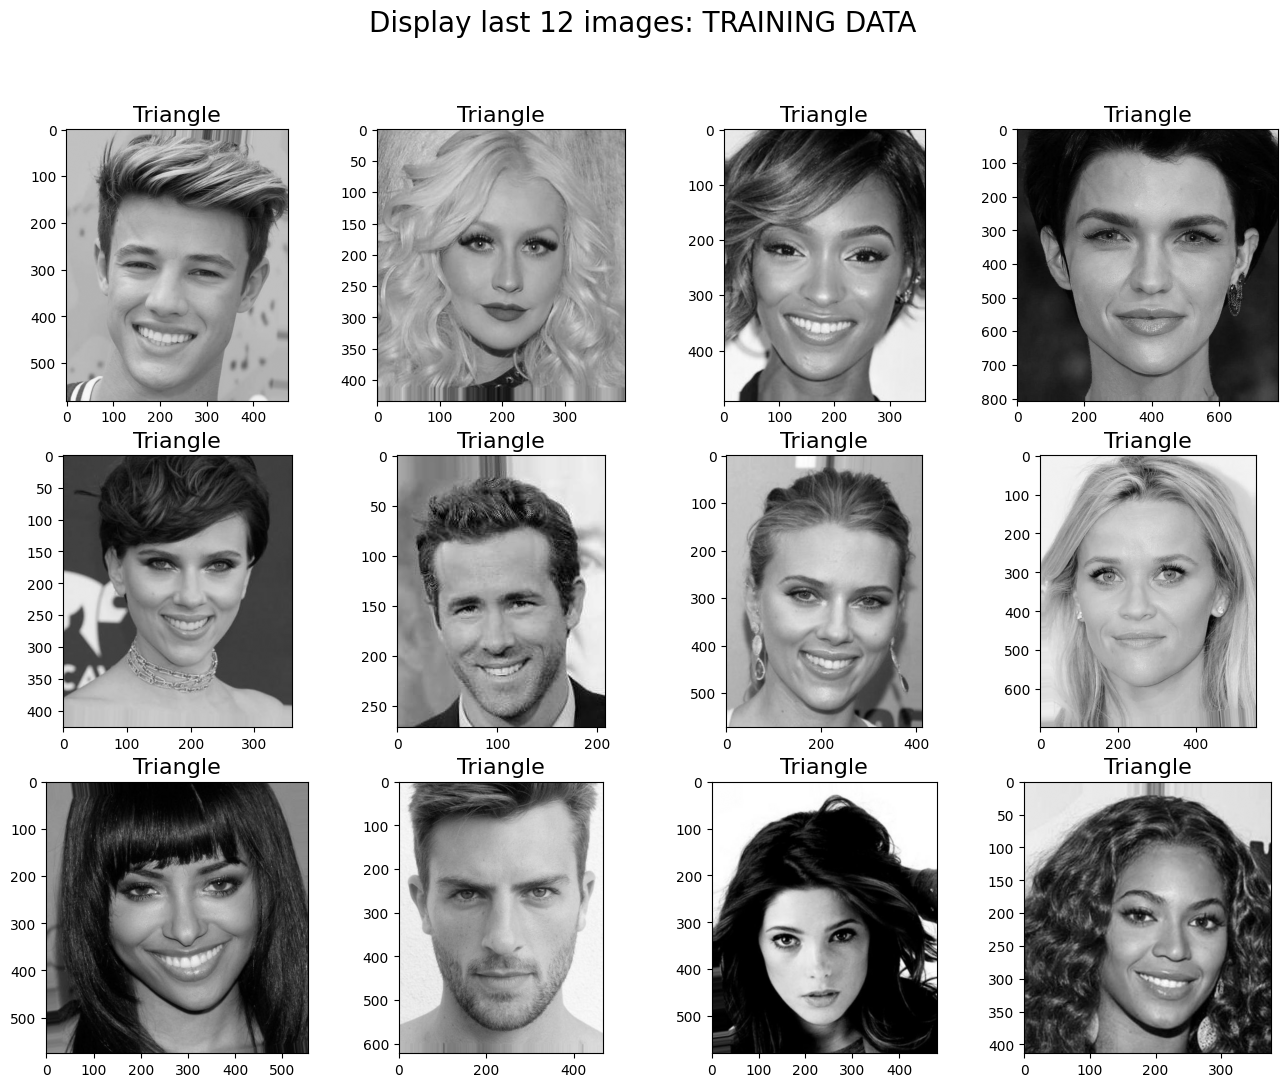

In [12]:
show_img(12, training_data[len(training_data)-12:], 'Display last 12 images: TRAINING DATA', ncols=4)

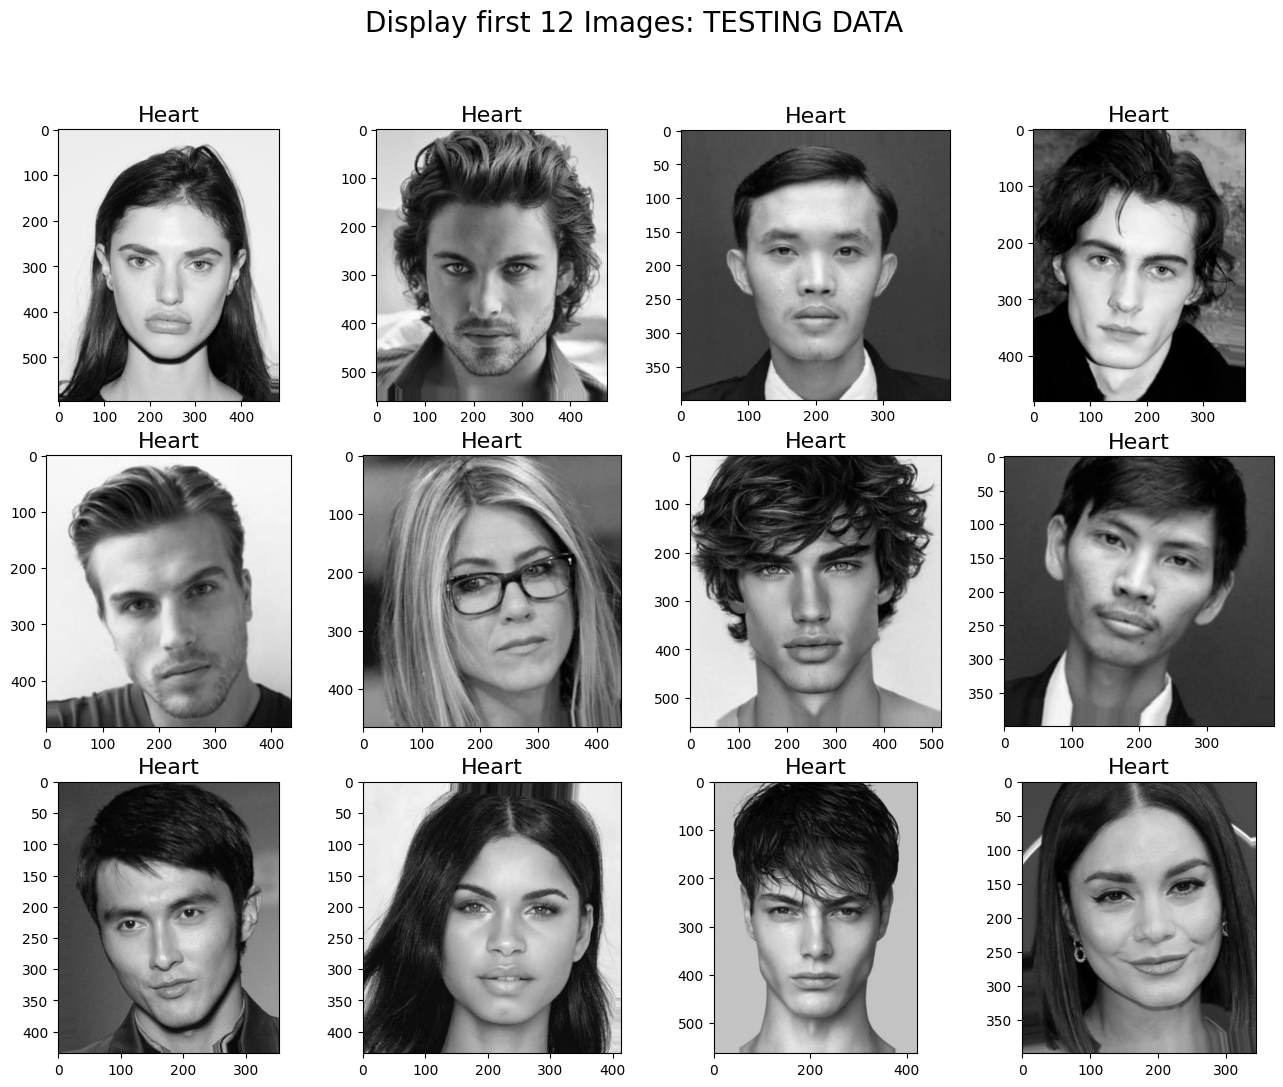

In [13]:
show_img(12, testing_data[:12], 'Display first 12 Images: TESTING DATA', ncols=4)

In [14]:
# Add all the image shapes into an array

shape = []

for image, label in training_data:
    try:
        img_shape = image.shape
        shape.append(img_shape)
    except AttributeError:
        print("shape not found")

shape[:5]

[(511, 397), (620, 508), (443, 369), (515, 514), (515, 514)]

In [15]:
# Create a data frame with the images and their shapes

train = pd.DataFrame(training_data, columns=['img_array','class'])
train['img_shape'] = pd.Series(shape)
train['face_shape'] = train['class'].map(label_map) 
train.head(2)

img_array class   img_shape  \
0  [[34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, ...     0  (511, 397)   
1  [[34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, ...     0  (620, 508)   

  face_shape  
0      Heart  
1      Heart

In [16]:
train.sort_values(by='img_shape', ascending=False)

img_array class     img_shape  \
1261  [[214, 215, 215, 215, 215, 214, 213, 212, 209,...     2  (3504, 2336)   
1304  [[216, 216, 216, 216, 216, 216, 216, 216, 216,...     2  (3504, 2336)   
1586  [[212, 212, 212, 212, 212, 212, 212, 212, 212,...     2  (3504, 2336)   
1297  [[202, 202, 202, 202, 202, 202, 202, 202, 203,...     2  (3504, 2336)   
1782  [[212, 212, 212, 212, 212, 212, 212, 212, 213,...     2  (3504, 2336)   
...                                                 ...   ...           ...   
3136  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     5    (192, 152)   
3368  [[219, 219, 219, 219, 219, 219, 219, 219, 219,...     5    (192, 152)   
3586  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     5    (192, 152)   
3232  [[221, 221, 221, 221, 221, 221, 221, 221, 220,...     5    (192, 152)   
3560  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     5    (192, 152)   

     face_shape  
1261       Oval  
1304       Oval  
1586       Oval  
1297       Oval  
1782       Oval  
...         ...  
3136   Triangle  
3368   Triangle  
3586   Triangle  
3232   Triangle  
3560   Triangle  

[3620 rows x 4 columns]

In [17]:
# Check the info, make sure there are no null values

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3620 entries, 0 to 3619
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_array   3620 non-null   object
 1   class       3620 non-null   object
 2   img_shape   3620 non-null   object
 3   face_shape  3620 non-null   object
dtypes: object(4)
memory usage: 113.3+ KB


In [18]:
# Create Height, Width, and Aspect Ratio for further analysis

train['height'] = train['img_shape'].map(lambda x : x[0])
train['width'] = train['img_shape'].map(lambda x : x[1])
train['aspect_ratio'] = train['width'] / train['height']
train

img_array class   img_shape  \
0     [[34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, ...     0  (511, 397)   
1     [[34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, ...     0  (620, 508)   
2     [[109, 109, 109, 109, 109, 109, 109, 109, 108,...     0  (443, 369)   
3     [[216, 216, 216, 215, 215, 214, 214, 214, 215,...     0  (515, 514)   
4     [[218, 218, 218, 218, 218, 218, 218, 218, 218,...     0  (515, 514)   
...                                                 ...   ...         ...   
3615  [[242, 242, 242, 242, 242, 242, 242, 242, 242,...     5  (698, 554)   
3616  [[142, 141, 141, 140, 140, 141, 141, 142, 138,...     5  (576, 556)   
3617  [[235, 234, 234, 234, 235, 237, 239, 241, 242,...     5  (622, 467)   
3618  [[254, 254, 254, 254, 254, 254, 254, 254, 254,...     5  (580, 481)   
3619  [[212, 212, 212, 212, 212, 212, 212, 212, 212,...     5  (414, 377)   

     face_shape  height  width  aspect_ratio  
0         Heart     511    397      0.776908  
1         Heart     620    508      0.819355  
2         Heart     443    369      0.832957  
3         Heart     515    514      0.998058  
4         Heart     515    514      0.998058  
...         ...     ...    ...           ...  
3615   Triangle     698    554      0.793696  
3616   Triangle     576    556      0.965278  
3617   Triangle     622    467      0.750804  
3618   Triangle     580    481      0.829310  
3619   Triangle     414    377      0.910628  

[3620 rows x 7 columns]

In [19]:
train.describe()

height        width  aspect_ratio
count  3620.000000  3620.000000   3620.000000
mean    515.896133   424.518785      0.833121
std     271.870725   213.202041      0.112812
min     192.000000   152.000000      0.577500
25%     383.000000   314.000000      0.751678
50%     478.500000   400.000000      0.814961
75%     574.000000   466.000000      0.904139
max    3504.000000  2510.000000      1.333333

In [20]:
# Defines a function to plot histograms showing comparative distributions of variables in a dataframe

def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels, list_of_ylabels, 
                       figsize=(10,8), bins = 15,ncols=2,nrows=0, sharex=True, sharey=True, figtitle=None):
    """plot histograms with subplots in matplotlib"""
    if nrows == 0:
        nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                           sharex=sharex, sharey=sharey) # You'll want to specify your figsize
    fig.suptitle(figtitle, fontsize=16)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column],bins=bins, color='mediumaquamarine') # feel free to add more settings
        ax[i].set_title(list_of_titles[i])# Set titles, labels, etc here for each subplot
        if (i >= (ncols*nrows)/2):
            ax[i].set_xlabel(list_of_xlabels[i])  # only show x labels on bottom ax plots
        if (sharey==True) and (i % ncols == 0):
            ax[i].set_ylabel(list_of_ylabels[i])  # only show y labels on left ax plots
    plt.tight_layout()
    # plt.savefig(f'../plots/{figtitle}.png');

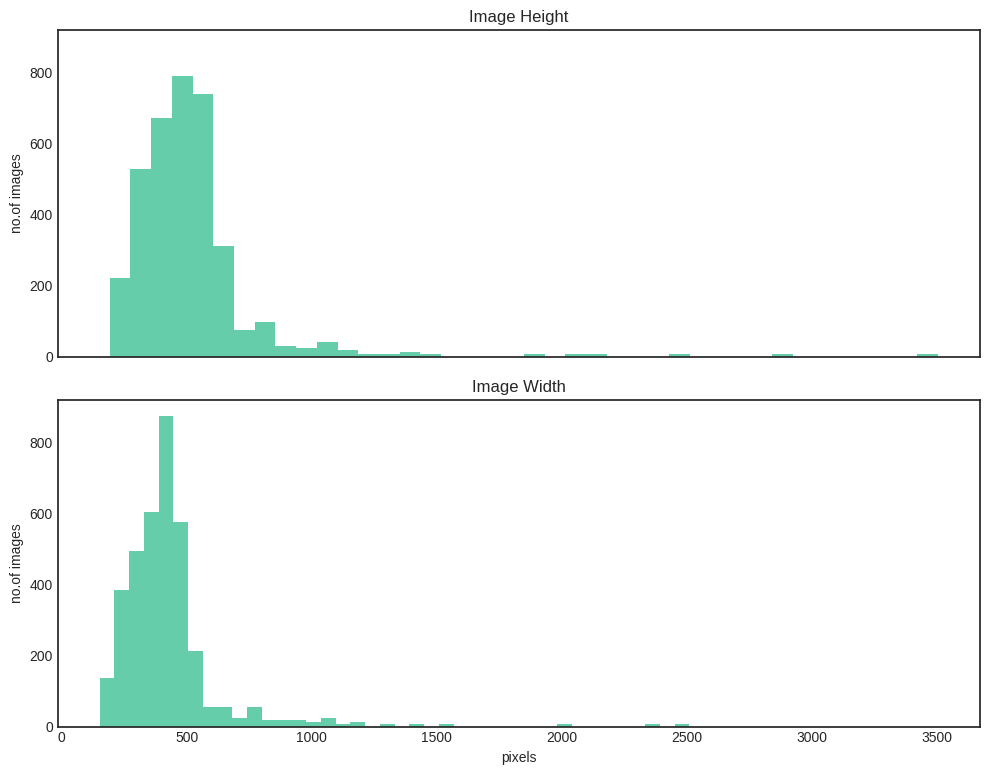

In [21]:

plt.style.use('seaborn-v0_8-white')
subplot_histograms(train, ['height', 'width'], 
                   ['Image Height', 'Image Width'], 
                   ['pixels','pixels'], 
                   ['no.of images','no.of images'], 
                   figsize=(10,8), bins = 40,ncols=1,nrows=2, 
                   sharex=True, sharey=True, figtitle=None)

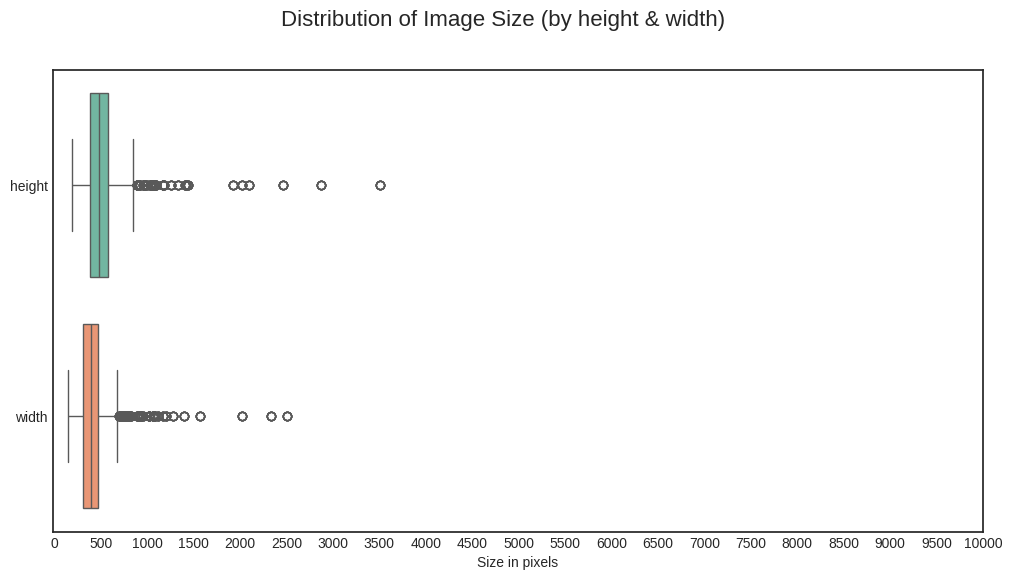

In [22]:
fig,ax = plt.subplots(figsize=(12,6))
fig.suptitle('Distribution of Image Size (by height & width)', fontsize=16)
sns.boxplot(data=train[['height', 'width']],orient='h', palette='Set2')
ax.set_xlabel('Size in pixels')
ax.set_xticks(range(0,10001, 500));
# sns.stripplot(data=train[['height', 'width']],orient='h', alpha=0.05);

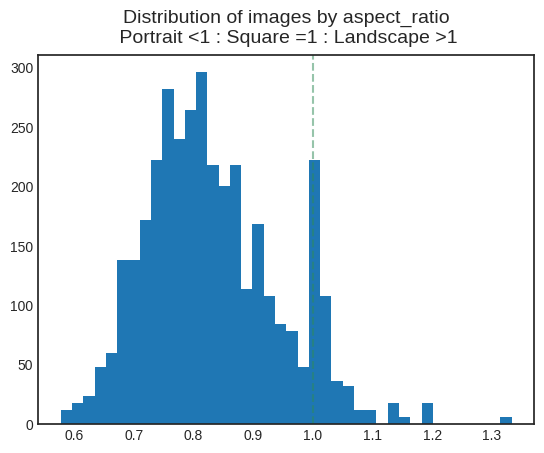

In [23]:
plt.hist(train['aspect_ratio'],bins=40)
plt.title('Distribution of images by aspect_ratio\n Portrait <1 : Square =1 : Landscape >1', fontsize = 14, y=1.01);
plt.axvline(x=1, alpha=0.5, linestyle='--', color='seagreen');

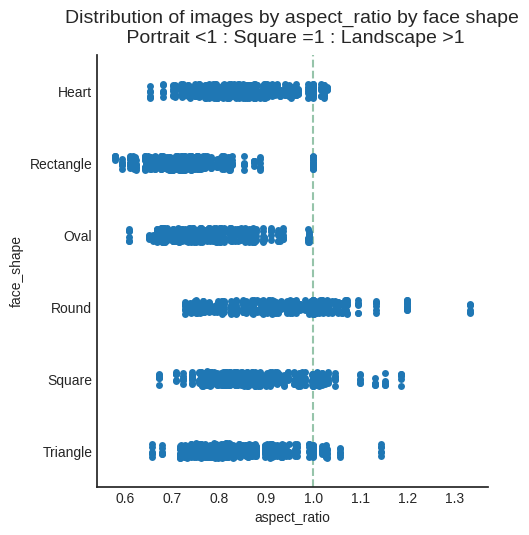

In [24]:
fig.suptitle('Image by Aspect Ratio (square=1)')
sns.catplot(data=train, x='aspect_ratio',y='face_shape')
plt.title('Distribution of images by aspect_ratio by face shape\n Portrait <1 : Square =1 : Landscape >1', fontsize = 14, y=1.01);
plt.axvline(x=1, alpha=0.5, linestyle='--', color='seagreen');

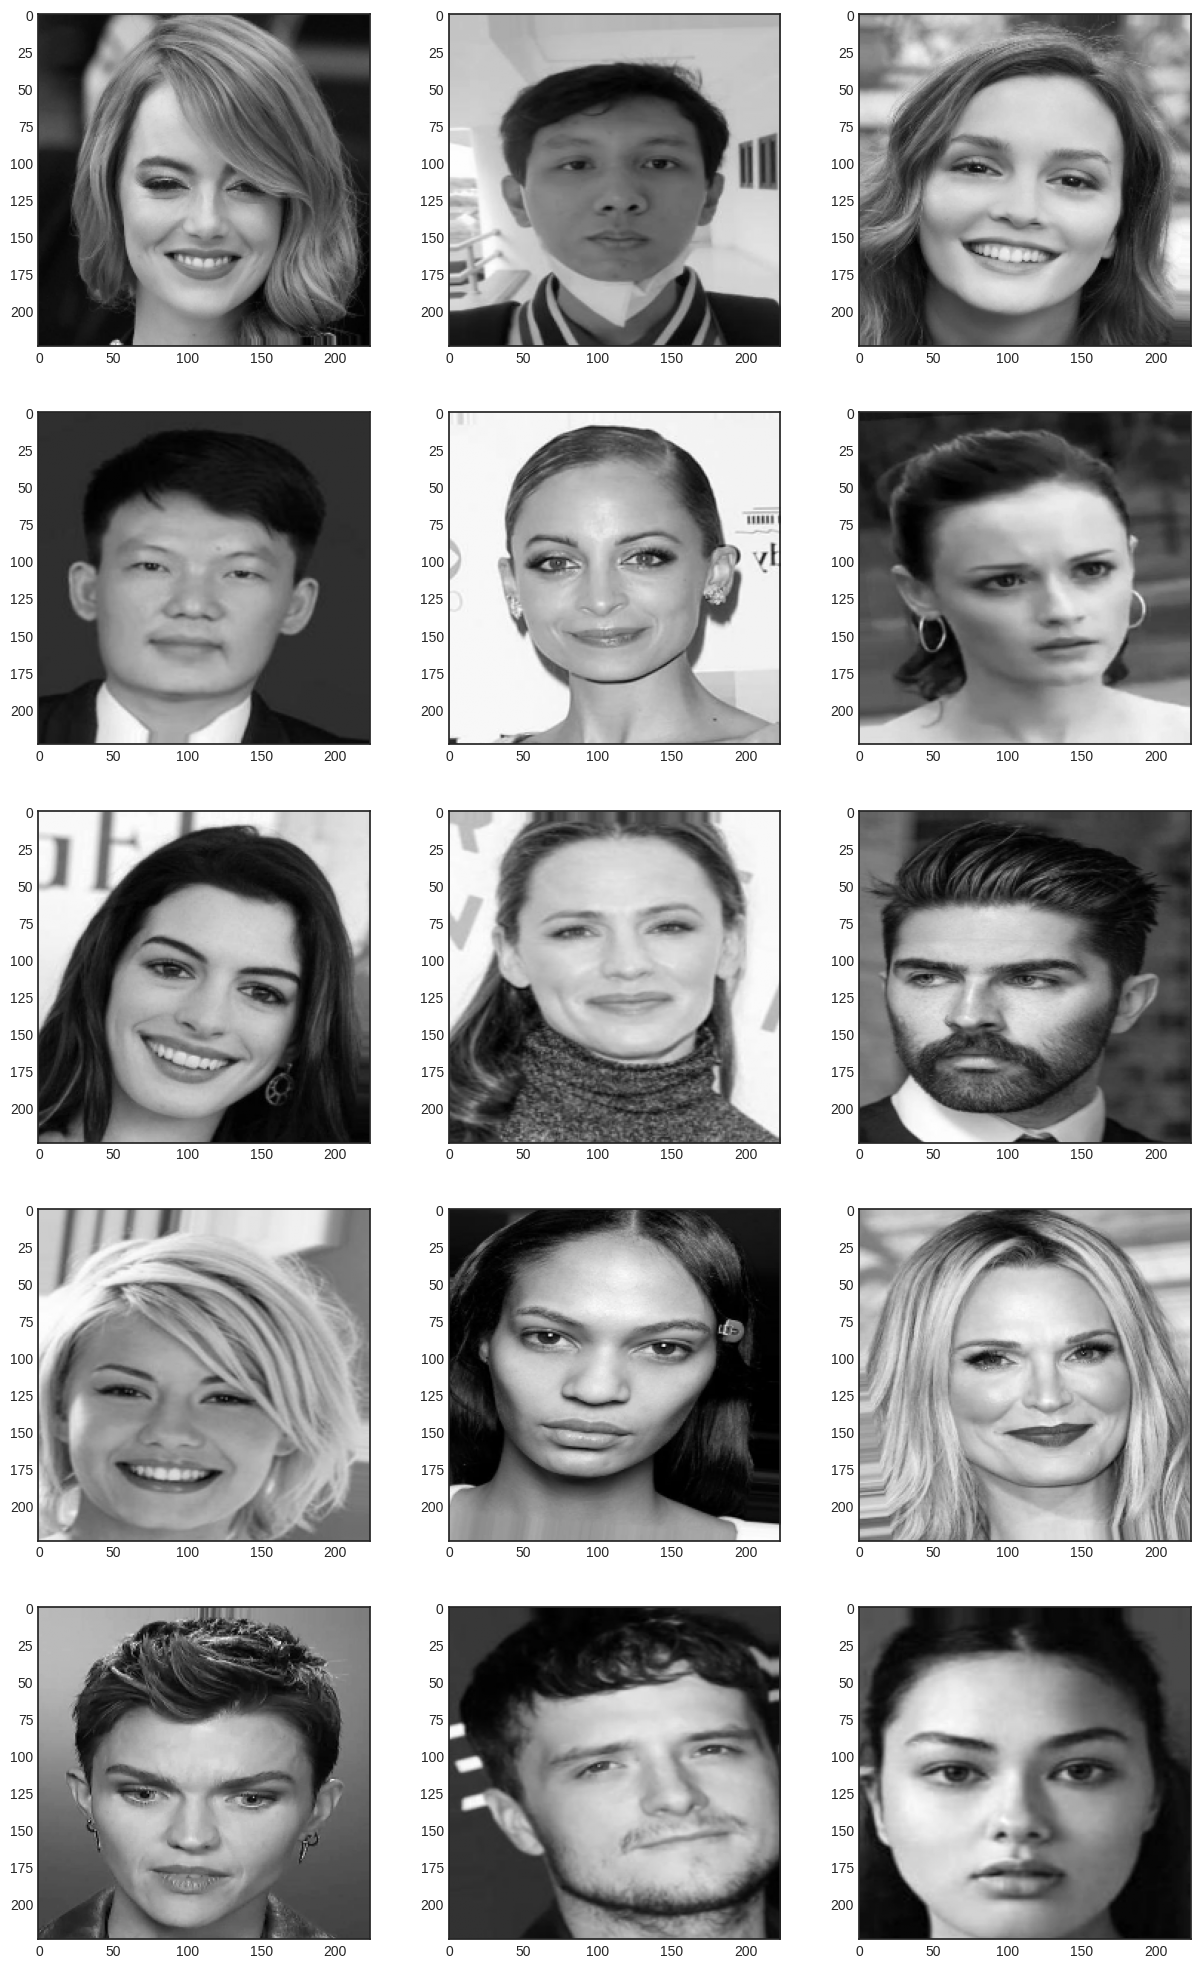

In [25]:
# let's randomly resize 10 images and see what they look like

randomlist = random.sample(range(0, 3620), 15)
img_size = 224
fig, ax = plt.subplots(nrows = 5, ncols=3, figsize = (15,25))
ax = ax.ravel()
for i,img in enumerate(randomlist):
    image = train.loc[img,'img_array']
    new_image = cv2.resize(image, (img_size, img_size))
    ax[i].imshow(new_image, cmap='gray')

In [26]:
def train_test_prep(training_data_array, testing_data_array):
    
    # shuffle the images to mix all the 5 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)
    
    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # change data types/format for X
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, nr_categories)  
    y_test = utils.to_categorical(y_test, nr_categories)

    return(X_train, X_test, y_train, y_test)

In [27]:
def pickle_out(X_train, X_test, y_train, y_test, version):
    '''to save the data out for modelling'''
    data_path = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data/'
    name_xtn = data_path + 'X_train_' + version +'.pickle'
    pickle_out = open(name_xtn,"wb")
    pickle.dump(X_train, pickle_out)
    pickle_out.close()

    name_ytn = data_path + 'y_train_' + version +'.pickle'
    pickle_out = open(name_ytn,"wb")
    pickle.dump(y_train, pickle_out)
    pickle_out.close()

    name_xts = data_path + 'X_test_' + version +'.pickle'
    pickle_out = open(name_xts,"wb")
    pickle.dump(X_test, pickle_out)
    pickle_out.close()

    name_yts = data_path + 'y_test_' + version +'.pickle'    
    pickle_out = open(name_yts,"wb")
    pickle.dump(y_test, pickle_out)
    pickle_out.close()

In [28]:
# create new training & testing data with resizing

training_data = []
testing_data = []

create_data_files(train_dir, training_data, (224,224))
create_data_files(test_dir, testing_data, (224,224))

In [29]:
X_train, X_test, y_train, y_test = train_test_prep(training_data, testing_data)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3620, 224, 224)
X_test.shape (1204, 224, 224)
y_train.shape (3620, 6)
y_test.shape (1204, 6)


In [30]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3620, 224, 224, 1)
X_test.shape (1204, 224, 224, 1)
y_train.shape (3620, 6)
y_test.shape (1204, 6)


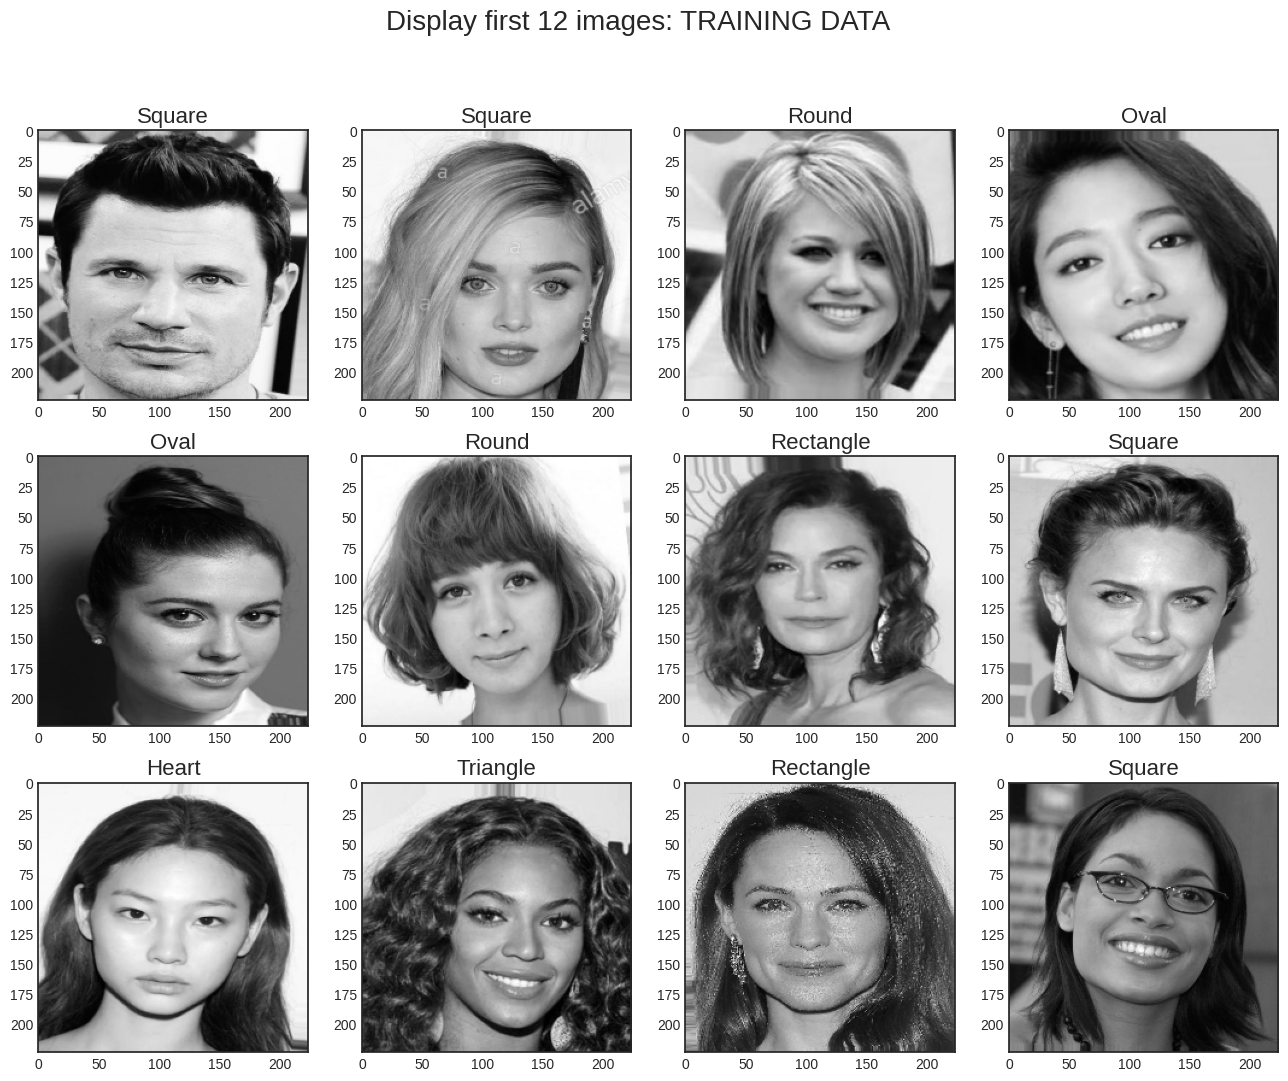

In [31]:
show_img(12, training_data[:12], 'Display first 12 images: TRAINING DATA', ncols=4)

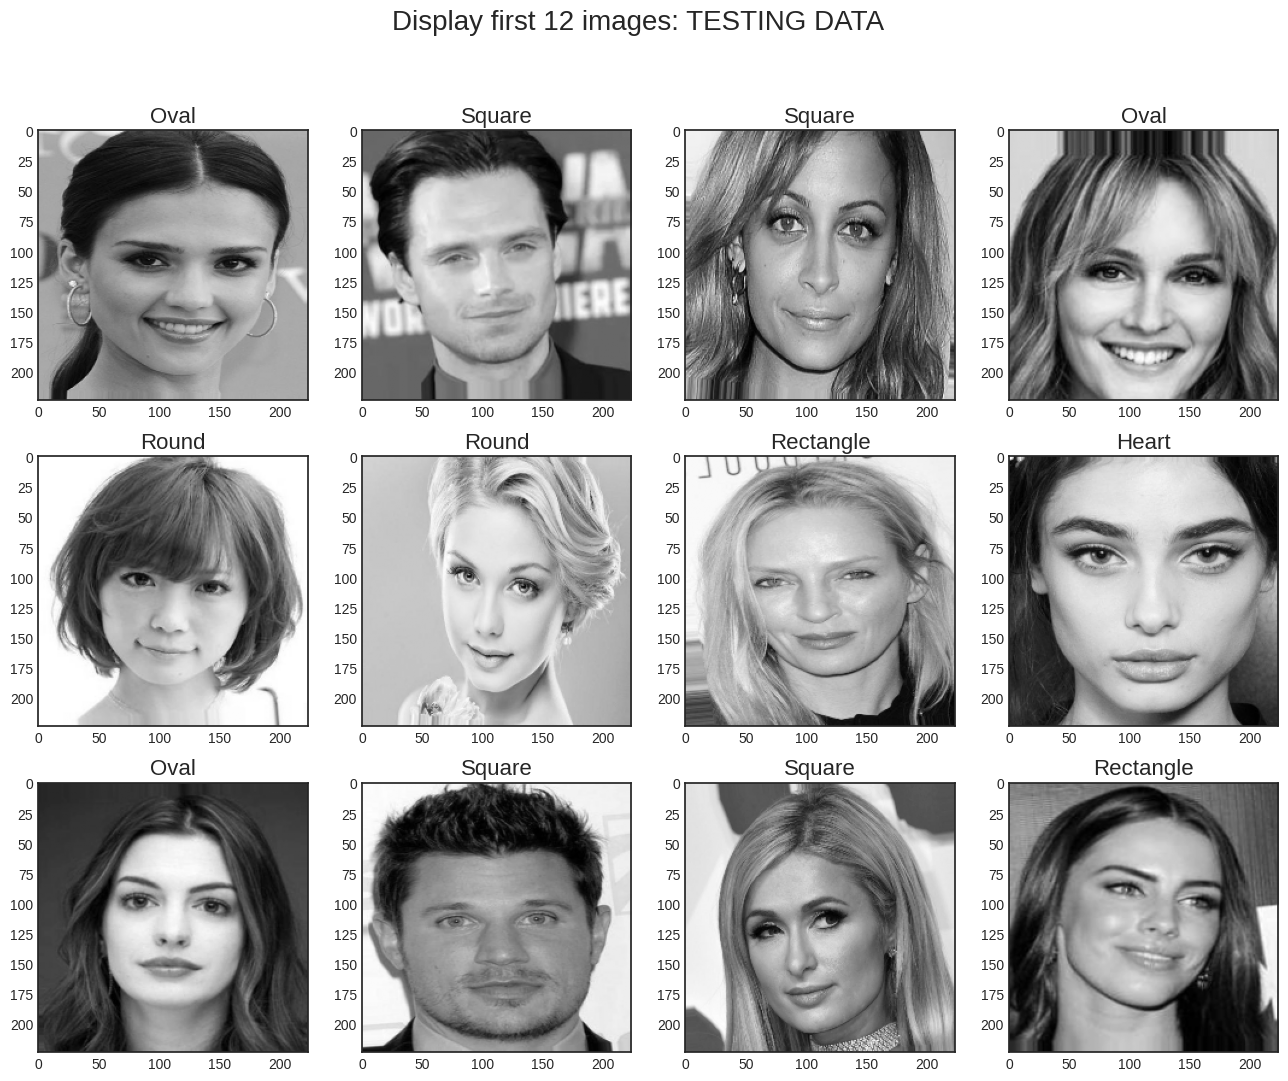

In [32]:
show_img(12, testing_data[:12], 'Display first 12 images: TESTING DATA', ncols=4)